In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is AIgeo_new2

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
print(tf.__version__)


2.0.0


In [2]:
#.............................................
# LOAD SAI DATA
#.............................................

# load and print netcdf data 

fn = 'precip/SAI/prect_CESM_WACCM_SAI_2035_2069_r1-10_daily_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

prec_SAI=np.array(ds['PRECT'][:])*1000*3600*24 # m/s --> mm/d
prec_SAI=prec_SAI.swapaxes(-1, -2)

lat=np.array(ds['lat'][:])
lon=np.array(ds['lon'][:])

del ds, fn

print('SAI DATA HAVE BEEN LOADED')


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SAI, daily PRECT, 2035-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(12775), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 PRECT(ensemble, time, lon, lat)
    groups: 
SAI DATA HAVE BEEN LOADED


In [3]:
#.............................................
# LOAD SSP DATA
#.............................................

# load and print netcdf data 

fn = 'precip/SSP2-4.5/prect_CESM_WACCM_SSP_2015_2069_r1-10_daily_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

prec_SSP=np.array(ds['PRECT'][:])*1000*3600*24 # m/s --> mm/d
prec_SSP=prec_SSP.swapaxes(-1, -2)

del ds, fn

print('SSP DATA HAVE BEEN LOADED')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SSP, daily PRECT, 2015-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(20075), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 PRECT(ensemble, time, lon, lat)
    groups: 
SSP DATA HAVE BEEN LOADED


In [4]:
#.............................................
# GET LAND MASK
#.............................................

# load and print netcdf data 

fn = 'soil_water/SAI/soilwater_CESM_WACCM_SAI_2035_2069_r1-10_monthly_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

landfrac=np.array(ds['LANDFRAC'][:])
landfrac=landfrac.swapaxes(-1, -2)

del ds, fn

print('landfrac DATA HAVE BEEN LOADED')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SAI, monthly soil water, 2035-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(420), level(20), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 SOILW(ensemble, level, time, lon, lat), float64 LANDFRAC(lon, lat)
    groups: 
landfrac DATA HAVE BEEN LOADED


In [5]:
# get series of annual mean and annual max precip

n_years_SAI=int((np.shape(prec_SAI)[1])/365)
prec_SAI_ann=prec_SAI[:,0:n_years_SAI,:,:]*0
prec_SAI_ann_max=np.copy(prec_SAI_ann)

for t in np.arange(0,n_years_SAI,1):
    prec_SAI_ann[:,t,:,:]=np.mean(prec_SAI[:,t*365:(t+1)*365,:,:],axis=1)
    prec_SAI_ann_max[:,t,:,:]=np.max(prec_SAI[:,t*365:(t+1)*365,:,:],axis=1)

n_years_SSP=int((np.shape(prec_SSP)[1])/365)
prec_SSP_ann=prec_SSP[:,0:n_years_SSP,:,:]*0
prec_SSP_ann_max=np.copy(prec_SSP_ann)

for t in np.arange(0,n_years_SSP,1):
    prec_SSP_ann[:,t,:,:]=np.mean(prec_SSP[:,t*365:(t+1)*365,:,:],axis=1)
    prec_SSP_ann_max[:,t,:,:]=np.max(prec_SSP[:,t*365:(t+1)*365,:,:],axis=1)

del prec_SAI, prec_SSP

In [6]:
#...........................................
# Calculate Global  Mean Precip for each year and SAI member
#...........................................

cosl=np.cos(np.pi*lat/180) #cos(lat) as a vector 
cosll=np.tile(cosl,(1,1,1,1))
coslat=np.tile(cosll,(10,n_years_SAI,144,1)) #replicate vector
coslat=np.swapaxes(coslat,-1,-2) #matrix of cos(lat)

landfrac_matrix=np.tile(landfrac,(1,1,1,1))
landfrac_matrix=np.tile(landfrac_matrix,(10,n_years_SAI,1,1)) #matrix of land fraction

#mean
GMP_sai=np.sum(np.multiply(prec_SAI_ann,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMP_land_sai=np.sum(np.multiply(np.multiply(prec_SAI_ann,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#max
GMPmax_sai=np.sum(np.multiply(prec_SAI_ann_max,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMPmax_land_sai=np.sum(np.multiply(np.multiply(prec_SAI_ann_max,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))

# also get annual max series over land 
prec_land_SAI_ann_max=np.multiply(prec_SAI_ann_max,landfrac_matrix)

In [7]:
#...........................................
# Calculate Global Mean Precip for each year and SSP member
#...........................................

cosl=np.cos(np.pi*lat/180) #cos(lat) as a vector 
cosll=np.tile(cosl,(1,1,1,1))
coslat=np.tile(cosll,(10,n_years_SSP,144,1)) #replicate vector
coslat=np.swapaxes(coslat,-1,-2) #matrix of cos(lat)

landfrac_matrix=np.tile(landfrac,(1,1,1,1))
landfrac_matrix=np.tile(landfrac_matrix,(10,n_years_SSP,1,1)) #matrix of land fraction

#mean
GMP_ssp=np.sum(np.multiply(prec_SSP_ann,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMP_land_ssp=np.sum(np.multiply(np.multiply(prec_SSP_ann,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#max
GMPmax_ssp=np.sum(np.multiply(prec_SSP_ann_max,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMPmax_land_ssp=np.sum(np.multiply(np.multiply(prec_SSP_ann_max,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))

# also get annual max series over land 
prec_land_SSP_ann_max=np.multiply(prec_SSP_ann_max,landfrac_matrix)

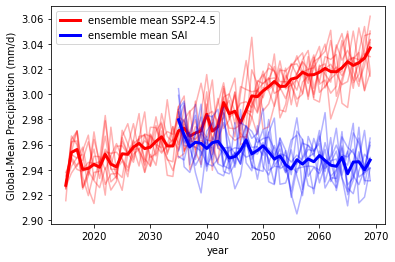

In [8]:
# plot global mean precip series

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMP_ssp[i,:],'r',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMP_ssp,axis=0),'r',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMP_sai[i,:],'b',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMP_sai,axis=0),'b',label='ensemble mean SAI', linewidth=3)

plt.xlabel('year')
plt.ylabel('Global-Mean Precipitation (mm/d)')
plt.axis('tight')
plt.legend()
plt.show()

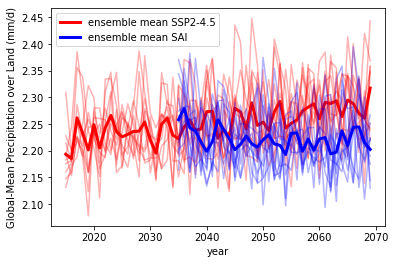

In [9]:
# plot global mean precip series over land

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMP_land_ssp[i,:],'r',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMP_land_ssp,axis=0),'r',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMP_land_sai[i,:],'b',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMP_land_sai,axis=0),'b',label='ensemble mean SAI', linewidth=3)

plt.xlabel('year')
plt.ylabel('Global-Mean Precipitation over Land (mm/d)')
plt.axis('tight')
plt.legend()
plt.show()

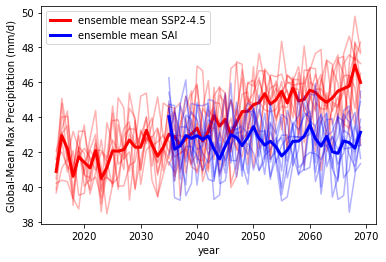

In [10]:
# plot global mean of annual max precip series

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMPmax_ssp[i,:],'r',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMPmax_ssp,axis=0),'r',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMPmax_sai[i,:],'b',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMPmax_sai,axis=0),'b',label='ensemble mean SAI', linewidth=3)

plt.xlabel('year')
plt.ylabel('Global-Mean Max Precipitation (mm/d)')
plt.axis('tight')
plt.legend()
plt.show()

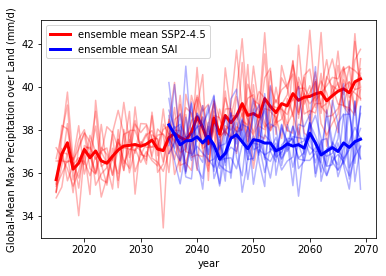

In [11]:
# plot global mean of annual max precip series over land

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMPmax_land_ssp[i,:],'r',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMPmax_land_ssp,axis=0),'r',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMPmax_land_sai[i,:],'b',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMPmax_land_sai,axis=0),'b',label='ensemble mean SAI', linewidth=3)

plt.xlabel('year')
plt.ylabel('Global-Mean Max Precipitation over Land (mm/d)')
plt.axis('tight')
plt.legend()
plt.show()

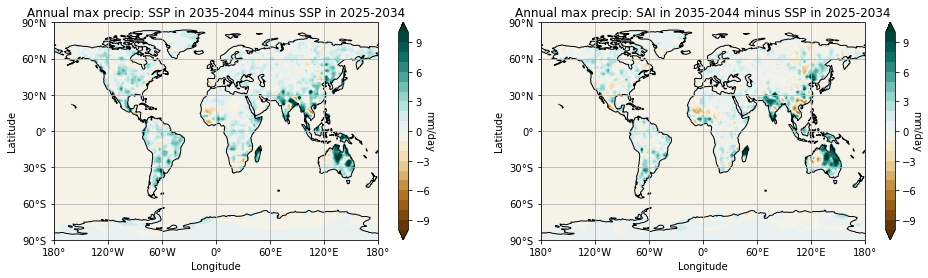

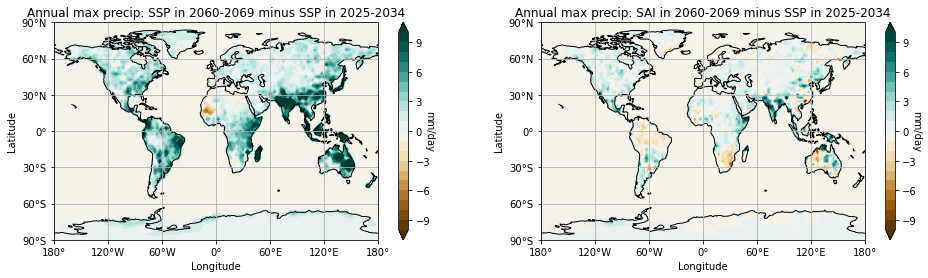

In [13]:
#PLOTTING SPATIAL PATTERNS OF CHANGE IN MAX PRECIP

plt.figure(figsize=(16,4))   
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(np.mean(prec_land_SSP_ann_max[:,20:30,:,:], axis=(0,1))-np.mean(prec_land_SSP_ann_max[:,10:20,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="BrBG",levels = np.linspace(-10,10,21),extend = 'both')
cbar = plt.colorbar(cs)   
cbar.set_label('mm/day', rotation=270)
plt.title('Annual max precip: SSP in 2035-2044 minus SSP in 2025-2034' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(np.mean(prec_land_SAI_ann_max[:,0:10,:,:], axis=(0,1))-np.mean(prec_land_SSP_ann_max[:,10:20,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="BrBG",levels = np.linspace(-10,10,21),extend = 'both')
cbar = plt.colorbar(cs)  
cbar.set_label('mm/day', rotation=270) 
plt.title('Annual max precip: SAI in 2035-2044 minus SSP in 2025-2034' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
plt.show()

plt.figure(figsize=(16,4))   
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(np.mean(prec_land_SSP_ann_max[:,45:55,:,:], axis=(0,1))-np.mean(prec_land_SSP_ann_max[:,10:20,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="BrBG",levels = np.linspace(-10,10,21),extend = 'both')
cbar = plt.colorbar(cs)   
cbar.set_label('mm/day', rotation=270)
plt.title('Annual max precip: SSP in 2060-2069 minus SSP in 2025-2034' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
samplep,lonp = add_cyclic_point(np.mean(prec_land_SAI_ann_max[:,25:35,:,:], axis=(0,1))-np.mean(prec_land_SSP_ann_max[:,10:20,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, cmap ="BrBG",levels = np.linspace(-10,10,21),extend = 'both')
cbar = plt.colorbar(cs)  
cbar.set_label('mm/day', rotation=270) 
plt.title('Annual max precip: SAI in 2060-2069 minus SSP in 2025-2034' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
plt.show()


In [101]:
#.............................................
# LOGISTIC REGRESSION FIT
#.............................................


def log_reg_fit(x_train,x_val,y_train,y_val,DROP_RATE=0.3,SEED=8889,LEARNING_RATE=0.001,BATCH_SIZE=32,NUM_EPOCHS=10000,PATIENCE=30,VERBOSITY=0):

  tf.keras.backend.clear_session()            
  tf.random.set_seed(SEED)
  np.random.seed(SEED) 
  
  # Constructing the model
  model = tf.keras.models.Sequential([ \

          tf.keras.layers.Dropout(DROP_RATE,seed=SEED,input_shape=x_train.shape[1:],),

          tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True, 
            bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)
            )])   

  #We will use the stochastic gradient descent (adam) optimizer
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              loss = 'binary_crossentropy', #Our loss function is based on categorical cross entropy
              metrics=['accuracy'], #We will print out the accuracy as the network is trained
              )

  # define early stopping callback
  EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=PATIENCE,
                                                   verbose=1,
                                                   mode='auto',
                                                   restore_best_weights=True)
              
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=VERBOSITY,callbacks=[EARLY_STOPPING])
          
  return model, history
    

/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping


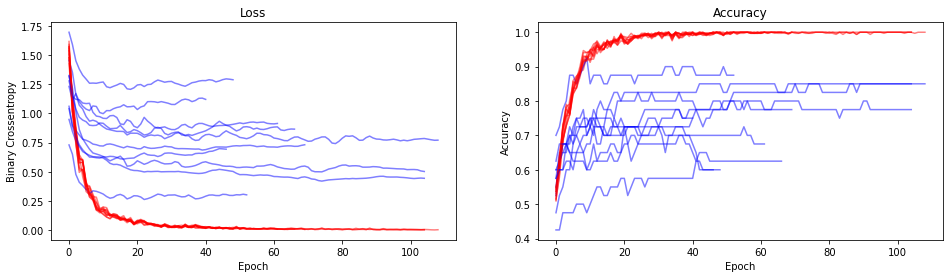

In [106]:
#.............................................
# TRAINING LOOP AND PLOT FOR SSP
#.............................................

landfrac_v=landfrac.reshape(landfrac.shape[0]*landfrac.shape[1])
set=np.arange(0,10)

# create lists for looping
predictions=[]
predictions_sai=[]
model_weights=[]

plt.figure(figsize=(16,4)) 

for m in np.arange(0,10,1):
 
 # build the training set
 train_set=np.delete(set,[m,m-1])

 # standardize
 X_train=(prec_land_SSP_ann_max[train_set,0:40,:,:]-np.mean(prec_land_SSP_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_ann_max[train_set,0:40,:,:], axis=(0,1)) # train members
 X_val=(prec_land_SSP_ann_max[m-1,0:40,:,:]-np.mean(prec_land_SSP_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_ann_max[train_set,0:40,:,:], axis=(0,1))   # val member
 X_test=(prec_land_SSP_ann_max[m,:,:,:]-np.mean(prec_land_SSP_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_ann_max[train_set,0:40,:,:], axis=(0,1))   # test member
 X_test_sai=(prec_land_SAI_ann_max[m,:,:,:]-np.mean(prec_land_SSP_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_ann_max[train_set,0:40,:,:], axis=(0,1))   # test sai member
 
 year=np.arange(2015,2055)
 Y_val=np.copy(year)
 Y_val[Y_val<2035]=0
 Y_val[Y_val>2034]=1
 Y_train=np.tile(Y_val,(8))

 
 # reshaping
 X_train=X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]*X_train.shape[3])
 X_val=X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
 X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
 X_test_sai=X_test_sai.reshape(X_test_sai.shape[0],X_test_sai.shape[1]*X_test_sai.shape[2])
 # keep only land grids
 X_train=np.delete(X_train,landfrac_v==0,1)
 X_val=np.delete(X_val,landfrac_v==0,1) 
 X_test=np.delete(X_test,landfrac_v==0,1) 
 X_test_sai=np.delete(X_test_sai,landfrac_v==0,1) 

 # fit logistic regression
 model,history =log_reg_fit(X_train,X_val,Y_train,Y_val)


 # keep a list of model weights
 model_weights.append(model.get_weights()[0])
 # Make the test prediction from the model 
 predictions.append(model.predict(X_test))
 # Make the sai test prediction from the model 
 predictions_sai.append(model.predict(X_test_sai))

 # plot training history
 plt.subplot(1,2,1)
 plt.plot(history.history['loss'],'r',alpha=0.5)
 plt.plot(history.history['val_loss'],'b',alpha=0.5)
 plt.title('Loss' ) 
 plt.xlabel('Epoch')
 plt.ylabel('Binary Crossentropy')
 plt.subplot(1,2,2)
 plt.plot(history.history['accuracy'],'r',alpha=0.5)
 plt.plot(history.history['val_accuracy'],'b',alpha=0.5)
 plt.title('Accuracy' ) 
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
plt.show()




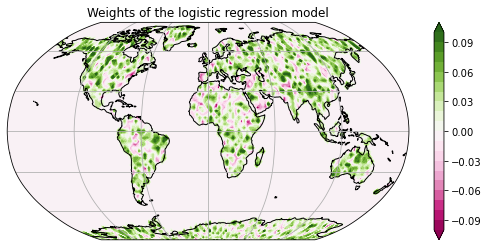

In [107]:
# Plot model weights (average across all training combos)

model_weights = np.array(model_weights)[:,:,0]
model_w = np.zeros((prec_land_SSP_ann_max.shape[0],prec_land_SSP_ann_max.shape[2]*prec_land_SSP_ann_max.shape[3]))
#model_w[:] = np.nan
model_w[:,landfrac_v==1]=model_weights
model_w=model_w[...,np.newaxis].reshape((model_w.shape[0],lat.shape[0],lon.shape[0]))

plt.figure(figsize=(9,4))   
ax=plt.axes(projection=ccrs.Robinson())
samplep,lonp = add_cyclic_point(np.mean(model_w, axis=0), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="PiYG",levels = np.linspace(-0.1,0.1,21),extend = 'both')
cbar = plt.colorbar(cs)   
#cbar.set_label('mm/day', rotation=270)
plt.title('Weights of the logistic regression model' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
plt.show()

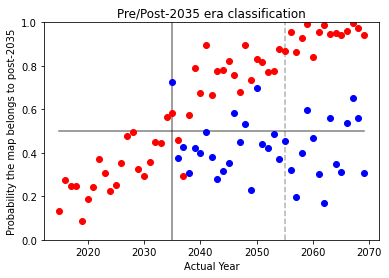

In [124]:
# plot test predictions

predictions = np.array(predictions)
predictions_sai = np.array(predictions_sai)

plt.plot(np.arange(2015,2070), 0.5*np.ones(predictions.shape[1]),'k-',alpha=0.5)
plt.plot(2035*np.ones(11), np.arange(0,1.1,0.1),'k-',alpha=0.5)
plt.plot(2055*np.ones(11), np.arange(0,1.1,0.1),'k--',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(predictions,axis=0),'ro')
#plt.errorbar(np.arange(2015,2070), np.mean(predictions,axis=0), yerr=np.std(predictions,axis=0).flatten(), fmt="o")
plt.plot(np.arange(2035,2070), np.mean(predictions_sai,axis=0),'bo')
plt.xlabel('Actual Year')
plt.ylabel('Probability the map belongs to post-2035')
plt.title('Pre/Post-2035 era classification') 
plt.axis('tight')
plt.ylim(0, 1)
#plt.legend()
plt.show()

In [141]:
# accruacy across all test samples

preds=np.copy(predictions)
preds[preds<0.5]=0
preds[preds>0.5]=1
years=np.arange(2015,2070)
years[years<2035]=0
years[years>2034]=1
print('The accuracy of the model across all testing samples is', np.mean(preds[:,:,0]==np.tile(np.tile(years,(1,1)),(10,1)), axis=(0,1)))

The accuracy of the model across all testing samples is 0.8


In [142]:
# switching data
prec_land_SSP_SAI_ann_max=np.concatenate((prec_land_SSP_ann_max[:,0:20,:,:],prec_land_SAI_ann_max),axis=1)
prec_land_SSP_end_ann_max=prec_land_SSP_ann_max[:,20:55,:,:]

/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/amamalakis/anaconda3/envs/AIgeo_new2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping


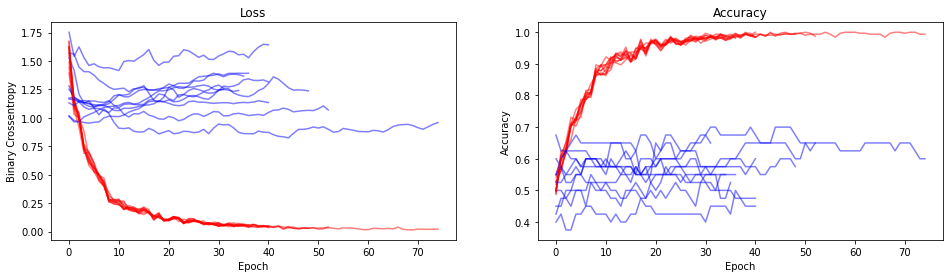

In [143]:
#.............................................
# TRAINING LOOP AND PLOT FOR SAI
#.............................................

landfrac_v=landfrac.reshape(landfrac.shape[0]*landfrac.shape[1])
set=np.arange(0,10)

# create lists for looping
predictions=[]
predictions_ssp=[]
model_weights=[]

plt.figure(figsize=(16,4)) 

for m in np.arange(0,10,1):
 
 # build the training set
 train_set=np.delete(set,[m,m-1])

 # standardize
 X_train=(prec_land_SSP_SAI_ann_max[train_set,0:40,:,:]-np.mean(prec_land_SSP_SAI_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_SAI_ann_max[train_set,0:40,:,:], axis=(0,1)) # train members
 X_val=(prec_land_SSP_SAI_ann_max[m-1,0:40,:,:]-np.mean(prec_land_SSP_SAI_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_SAI_ann_max[train_set,0:40,:,:], axis=(0,1))   # val member
 X_test=(prec_land_SSP_SAI_ann_max[m,:,:,:]-np.mean(prec_land_SSP_SAI_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_SAI_ann_max[train_set,0:40,:,:], axis=(0,1))   # test member
 X_test_ssp=(prec_land_SSP_end_ann_max[m,:,:,:]-np.mean(prec_land_SSP_SAI_ann_max[train_set,15:25,:,:], axis=(0,1)))/np.std(prec_land_SSP_SAI_ann_max[train_set,0:40,:,:], axis=(0,1))   # test sai member
 
 year=np.arange(2015,2055)
 Y_val=np.copy(year)
 Y_val[Y_val<2035]=0
 Y_val[Y_val>2034]=1
 Y_train=np.tile(Y_val,(8))

 
 # reshaping
 X_train=X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]*X_train.shape[3])
 X_val=X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
 X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
 X_test_ssp=X_test_ssp.reshape(X_test_ssp.shape[0],X_test_ssp.shape[1]*X_test_ssp.shape[2])
 # keep only land grids
 X_train=np.delete(X_train,landfrac_v==0,1)
 X_val=np.delete(X_val,landfrac_v==0,1) 
 X_test=np.delete(X_test,landfrac_v==0,1) 
 X_test_ssp=np.delete(X_test_ssp,landfrac_v==0,1) 

 # fit logistic regression
 model,history =log_reg_fit(X_train,X_val,Y_train,Y_val)


 # keep a list of model weights
 model_weights.append(model.get_weights()[0])
 # Make the test prediction from the model 
 predictions.append(model.predict(X_test))
 # Make the sai test prediction from the model 
 predictions_ssp.append(model.predict(X_test_ssp))

 # plot training history
 plt.subplot(1,2,1)
 plt.plot(history.history['loss'],'r',alpha=0.5)
 plt.plot(history.history['val_loss'],'b',alpha=0.5)
 plt.title('Loss' ) 
 plt.xlabel('Epoch')
 plt.ylabel('Binary Crossentropy')
 plt.subplot(1,2,2)
 plt.plot(history.history['accuracy'],'r',alpha=0.5)
 plt.plot(history.history['val_accuracy'],'b',alpha=0.5)
 plt.title('Accuracy' ) 
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
plt.show()



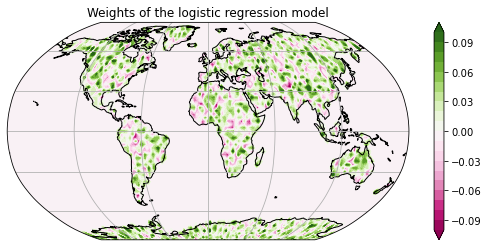

In [144]:
# Plot model weights (average across all training combos)

model_weights = np.array(model_weights)[:,:,0]
model_w = np.zeros((prec_land_SSP_SAI_ann_max.shape[0],prec_land_SSP_SAI_ann_max.shape[2]*prec_land_SSP_SAI_ann_max.shape[3]))
#model_w[:] = np.nan
model_w[:,landfrac_v==1]=model_weights
model_w=model_w[...,np.newaxis].reshape((model_w.shape[0],lat.shape[0],lon.shape[0]))

plt.figure(figsize=(9,4))   
ax=plt.axes(projection=ccrs.Robinson())
samplep,lonp = add_cyclic_point(np.mean(model_w, axis=0), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="PiYG",levels = np.linspace(-0.1,0.1,21),extend = 'both')
cbar = plt.colorbar(cs)   
#cbar.set_label('mm/day', rotation=270)
plt.title('Weights of the logistic regression model' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines()
#plt.legend()
plt.show()

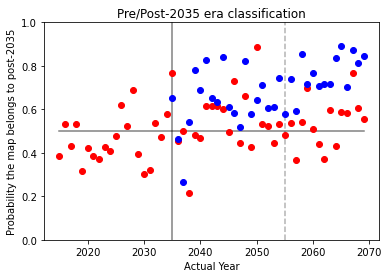

In [145]:
# plot test predictions

predictions = np.array(predictions)
predictions_ssp = np.array(predictions_ssp)

plt.plot(np.arange(2015,2070), 0.5*np.ones(predictions.shape[1]),'k-',alpha=0.5)
plt.plot(2035*np.ones(11), np.arange(0,1.1,0.1),'k-',alpha=0.5)
plt.plot(2055*np.ones(11), np.arange(0,1.1,0.1),'k--',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(predictions,axis=0),'ro')
#plt.errorbar(np.arange(2015,2070), np.mean(predictions,axis=0), yerr=np.std(predictions,axis=0).flatten(), fmt="o")
plt.plot(np.arange(2035,2070), np.mean(predictions_ssp,axis=0),'bo')
plt.xlabel('Actual Year')
plt.ylabel('Probability the map belongs to post-2035')
plt.title('Pre/Post-2035 era classification') 
plt.axis('tight')
plt.ylim(0, 1)
#plt.legend()
plt.show()

In [146]:
# accruacy across all test samples

preds=np.copy(predictions)
preds[preds<0.5]=0
preds[preds>0.5]=1
years=np.arange(2015,2070)
years[years<2035]=0
years[years>2034]=1
print('The accuracy of the model across all testing samples is', np.mean(preds[:,:,0]==np.tile(np.tile(years,(1,1)),(10,1)), axis=(0,1)))

The accuracy of the model across all testing samples is 0.5563636363636364
